## mnist_back_prop

In [1]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [3]:
# parameters
learning_rate = 0.5
batch_size = 10

In [4]:
# Mnist dataset
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True,
                          transform = transforms.ToTensor(),
                          download = True)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                          train = False,
                          transform = transforms.ToTensor(),
                          download = True)

In [5]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True)

In [6]:
w1 = torch.nn.Parameter(torch.Tensor(784, 30)).to(device)
b1 = torch.nn.Parameter(torch.Tensor(30)).to(device)
w2 = torch.nn.Parameter(torch.Tensor(30, 10)).to(device)
b2 = torch.nn.Parameter(torch.Tensor(10)).to(device)

In [7]:
# noramlization
torch.nn.init.normal_(w1)
torch.nn.init.normal_(b1)
torch.nn.init.normal_(w2)
torch.nn.init.normal_(b2)

tensor([ 0.1009, -0.2272, -0.1022, -0.9369,  0.6552, -0.8914,  0.1989,  0.7264,
         0.3932, -0.5963], device='cuda:0', grad_fn=<CopyBackwards>)

In [8]:
def sigmoid(x):
    return 1.0 /  (1.0 + torch.exp(-x))

In [9]:
def sigmoid_prime(x):
    # derivative of the sigmoid function
    return sigmoid(x) * (1 - sigmoid(x))

In [10]:
X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)[:1000]
Y_test = mnist_test.test_labels.to(device)[:1000]
i = 0
while not i == 10000:
    for X, Y in data_loader:
        i += 1

        # forward
        X = X.view(-1, 28 * 28).to(device)
        Y = torch.zeros((batch_size, 10)).scatter_(1, Y.unsqueeze(1), 1).to(device)    # one-hot
        l1 = torch.add(torch.matmul(X, w1), b1)
        a1 = sigmoid(l1)
        l2 = torch.add(torch.matmul(a1, w2), b2)
        y_pred = sigmoid(l2)

        diff = y_pred - Y

        # Back prop (chain rule)
        d_l2 = diff * sigmoid_prime(l2)
        d_b2 = d_l2
        d_w2 = torch.matmul(torch.transpose(a1, 0, 1), d_l2)

        d_a1 = torch.matmul(d_l2, torch.transpose(w2, 0, 1))
        d_l1 = d_a1 * sigmoid_prime(l1)
        d_b1 = d_l1
        d_w1 = torch.matmul(torch.transpose(X, 0, 1), d_l1)

        w1 = w1 - learning_rate * d_w1
        b1 = b1 - learning_rate * torch.mean(d_b1, 0)
        w2 = w2 - learning_rate * d_w2
        b2 = b2 - learning_rate * torch.mean(d_b2, 0)

        if i % 1000 == 0:
            l1 = torch.add(torch.matmul(X_test, w1), b1)
            a1 = sigmoid(l1)
            l2 = torch.add(torch.matmul(a1, w2), b2)
            y_pred = sigmoid(l2)
            acct_mat = torch.argmax(y_pred, 1) == Y_test
            acct_res = acct_mat.sum()
            print(acct_res.item())

        if i == 10000:
            break

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


778
849
860
863
889
889
883
896
906
918


## mnist Softmax

In [11]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [13]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [14]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [15]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [16]:
# MNIST data image of shape 28 * 28 = 784
linear = torch.nn.Linear(784, 10, bias=True).to(device)

In [17]:
# Initialization
torch.nn.init.normal_(linear.weight)

Parameter containing:
tensor([[-1.2901,  0.3930, -0.1891,  ..., -0.1626, -0.3275,  0.5608],
        [-1.6757, -0.2454,  0.9221,  ...,  0.9559,  0.6160, -0.4226],
        [ 0.2444,  1.4810, -2.0906,  ...,  0.1206,  1.0044, -0.3737],
        ...,
        [ 0.6234,  1.8019, -2.7563,  ..., -0.5889, -0.5576,  0.7360],
        [-0.2871, -1.3313, -2.2248,  ...,  0.0309,  0.9180, -0.1482],
        [ 0.7678,  0.6624, -0.5362,  ...,  0.2338,  0.3688, -0.7182]],
       device='cuda:0', requires_grad=True)

In [18]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(linear.parameters(), lr = learning_rate)

In [19]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 5.655342102
Epoch: 0002 cost = 1.696972847
Epoch: 0003 cost = 1.122007370
Epoch: 0004 cost = 0.883580327
Epoch: 0005 cost = 0.750404954
Epoch: 0006 cost = 0.663256943
Epoch: 0007 cost = 0.600838780
Epoch: 0008 cost = 0.554966509
Epoch: 0009 cost = 0.518606186
Epoch: 0010 cost = 0.489761561
Epoch: 0011 cost = 0.465993166
Epoch: 0012 cost = 0.446268976
Epoch: 0013 cost = 0.429332823
Epoch: 0014 cost = 0.414647251
Epoch: 0015 cost = 0.401718795
Learning finished


In [20]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.8826999664306641
Label:  8
Prediction:  3


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## mnist_nn

In [21]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [23]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [24]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [25]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [26]:
# nn layers
linear1 = torch.nn.Linear(784, 256, bias = True)
linear2 = torch.nn.Linear(256, 256, bias = True)
linear3 = torch.nn.Linear(256, 10, bias = True)
relu = torch.nn.ReLU()

In [27]:
# Initialization
torch.nn.init.normal_(linear1.weight)
torch.nn.init.normal_(linear2.weight)
torch.nn.init.normal_(linear3.weight)

Parameter containing:
tensor([[-0.6645,  0.6646,  0.7159,  ..., -0.3040, -0.8945, -0.7977],
        [-1.2045,  2.4545, -1.8073,  ..., -1.7139, -0.0451,  0.3864],
        [ 0.3414,  0.3114, -1.9218,  ..., -0.4525, -0.6849,  0.9663],
        ...,
        [ 1.3915, -0.4048,  0.2338,  ..., -0.8257, -0.8397,  1.9816],
        [ 1.0414,  0.2130, -0.0417,  ...,  1.7541, -0.6454, -0.0821],
        [-0.1162, -1.2692,  0.8201,  ..., -0.8303, -0.5022,  0.0583]],
       requires_grad=True)

In [28]:
# model
model = torch.nn.Sequential(
    linear1, relu, 
    linear2, relu, 
    linear3).to(device)

In [29]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [31]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.4f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 129.4140
Epoch: 0002 cost = 35.8641
Epoch: 0003 cost = 22.7343
Epoch: 0004 cost = 15.7546
Epoch: 0005 cost = 11.5656
Epoch: 0006 cost = 8.5170
Epoch: 0007 cost = 6.3635
Epoch: 0008 cost = 4.8400
Epoch: 0009 cost = 3.5078
Epoch: 0010 cost = 2.6628
Epoch: 0011 cost = 2.0796
Epoch: 0012 cost = 1.5012
Epoch: 0013 cost = 1.2556
Epoch: 0014 cost = 0.9753
Epoch: 0015 cost = 0.7936
Learning finished


In [32]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9455999732017517
Label:  9
Prediction:  9


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## mnist_nn_xavier

In [33]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [35]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [36]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [37]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [38]:
# nn layers
linear1 = torch.nn.Linear(784, 256, bias=True)
linear2 = torch.nn.Linear(256, 256, bias=True)
linear3 = torch.nn.Linear(256, 10, bias=True)
relu = torch.nn.ReLU()

In [39]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)

Parameter containing:
tensor([[-0.0215, -0.0894,  0.0598,  ...,  0.0200,  0.0203,  0.1212],
        [ 0.0078,  0.1378,  0.0920,  ...,  0.0975,  0.1458, -0.0302],
        [ 0.1270, -0.1296,  0.1049,  ...,  0.0124,  0.1173, -0.0901],
        ...,
        [ 0.0661, -0.1025,  0.1437,  ...,  0.0784,  0.0977, -0.0396],
        [ 0.0430, -0.1274, -0.0134,  ..., -0.0582,  0.1201,  0.1479],
        [-0.1433,  0.0200, -0.0568,  ...,  0.0787,  0.0428, -0.0036]],
       requires_grad=True)

In [40]:
# model
model = torch.nn.Sequential(
    linear1, relu, 
    linear2, relu, 
    linear3).to(device)

In [41]:
loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [42]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.4f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.2468
Epoch: 0002 cost = 0.0933
Epoch: 0003 cost = 0.0609
Epoch: 0004 cost = 0.0434
Epoch: 0005 cost = 0.0336
Epoch: 0006 cost = 0.0254
Epoch: 0007 cost = 0.0223
Epoch: 0008 cost = 0.0185
Epoch: 0009 cost = 0.0161
Epoch: 0010 cost = 0.0148
Epoch: 0011 cost = 0.0106
Epoch: 0012 cost = 0.0133
Epoch: 0013 cost = 0.0132
Epoch: 0014 cost = 0.0133
Epoch: 0015 cost = 0.0073
Learning finished


In [43]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9801999926567078
Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## mnist_nn_deep

In [44]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cuda


In [46]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [47]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [48]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [49]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()

In [50]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [51]:
# model
model = torch.nn.Sequential(
    linear1, relu, 
    linear2, relu, 
    linear3, relu,
    linear4, relu,
    linear5
    ).to(device)

In [52]:
# define cost/loss & optimizer
loss = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
total_batch = len(data_loader)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.212040082
Epoch: 0002 cost = 0.091445811
Epoch: 0003 cost = 0.063702054
Epoch: 0004 cost = 0.050078157
Epoch: 0005 cost = 0.042393684
Epoch: 0006 cost = 0.033861235
Epoch: 0007 cost = 0.029869644
Epoch: 0008 cost = 0.027892672
Epoch: 0009 cost = 0.023878690
Epoch: 0010 cost = 0.022307266
Epoch: 0011 cost = 0.019761587
Epoch: 0012 cost = 0.020827059
Epoch: 0013 cost = 0.015726311
Epoch: 0014 cost = 0.016777121
Epoch: 0015 cost = 0.014648413
Learning finished


In [54]:
# Test the model using test sets
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9818999767303467
Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## mnist_nn_dropout

In [55]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import random

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [57]:
# parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100
drop_prob = 0.3

In [58]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [59]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [60]:
# nn layers
linear1 = torch.nn.Linear(784, 512, bias=True)
linear2 = torch.nn.Linear(512, 512, bias=True)
linear3 = torch.nn.Linear(512, 512, bias=True)
linear4 = torch.nn.Linear(512, 512, bias=True)
linear5 = torch.nn.Linear(512, 10, bias=True)
relu = torch.nn.ReLU()
dropout = torch.nn.Dropout(p=drop_prob)

In [61]:
# xavier initialization
torch.nn.init.xavier_uniform_(linear1.weight)
torch.nn.init.xavier_uniform_(linear2.weight)
torch.nn.init.xavier_uniform_(linear3.weight)
torch.nn.init.xavier_uniform_(linear4.weight)
torch.nn.init.xavier_uniform_(linear5.weight)

Parameter containing:
tensor([[-0.0565,  0.0423, -0.0155,  ...,  0.1012,  0.0459, -0.0191],
        [ 0.0772,  0.0452, -0.0638,  ...,  0.0476, -0.0638,  0.0528],
        [ 0.0311, -0.1023, -0.0701,  ...,  0.0412, -0.1004,  0.0738],
        ...,
        [ 0.0334,  0.0187, -0.1021,  ...,  0.0280, -0.0583, -0.1018],
        [-0.0506, -0.0939, -0.0467,  ..., -0.0554, -0.0325,  0.0640],
        [-0.0183, -0.0123,  0.1025,  ..., -0.0214,  0.0220, -0.0741]],
       requires_grad=True)

In [62]:
# model
model = torch.nn.Sequential(linear1, relu, dropout,
                            linear2, relu, dropout,
                            linear3, relu, dropout,
                            linear4, relu, dropout,
                            linear5).to(device)

In [63]:
# define cost/loss & optimizer
loss = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [64]:
total_batch = len(data_loader)
model.train()    # set the model to train mode (dropout=True)
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = loss(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.308313370
Epoch: 0002 cost = 0.145537242
Epoch: 0003 cost = 0.113822021
Epoch: 0004 cost = 0.094595984
Epoch: 0005 cost = 0.081666991
Epoch: 0006 cost = 0.074699230
Epoch: 0007 cost = 0.068649076
Epoch: 0008 cost = 0.064225532
Epoch: 0009 cost = 0.058307916
Epoch: 0010 cost = 0.055906847
Epoch: 0011 cost = 0.049039021
Epoch: 0012 cost = 0.050934989
Epoch: 0013 cost = 0.050525025
Epoch: 0014 cost = 0.044698771
Epoch: 0015 cost = 0.040474072
Learning finished


In [65]:
# Test model and check accuracy
with torch.no_grad():
    model.eval()    # set the model to evaluation mode (dropout=False)

    # Test the model using test sets
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

Accuracy: 0.9764999747276306
Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


## mnist_batchnorm

In [66]:
# Lab 10 MNIST and softmax
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

cuda


In [68]:
# parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [69]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

In [70]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [71]:
# nn layers
linear1 = torch.nn.Linear(784, 32, bias=True)
linear2 = torch.nn.Linear(32, 32, bias=True)
linear3 = torch.nn.Linear(32, 10, bias=True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32)
bn2 = torch.nn.BatchNorm1d(32)

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [72]:
# model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
                            
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [73]:
# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [74]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.14593(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.19554(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.15965(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.21082(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09883(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19223(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.11133(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.21578(nn_acc:0.94)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07933(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.17172(nn_acc:0.95)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.10172(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.20931(nn_acc:0.94)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07281(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.15079(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.10456(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19461(nn_acc:0.95)

[Epoch 5-TRAIN] Batc

In [75]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

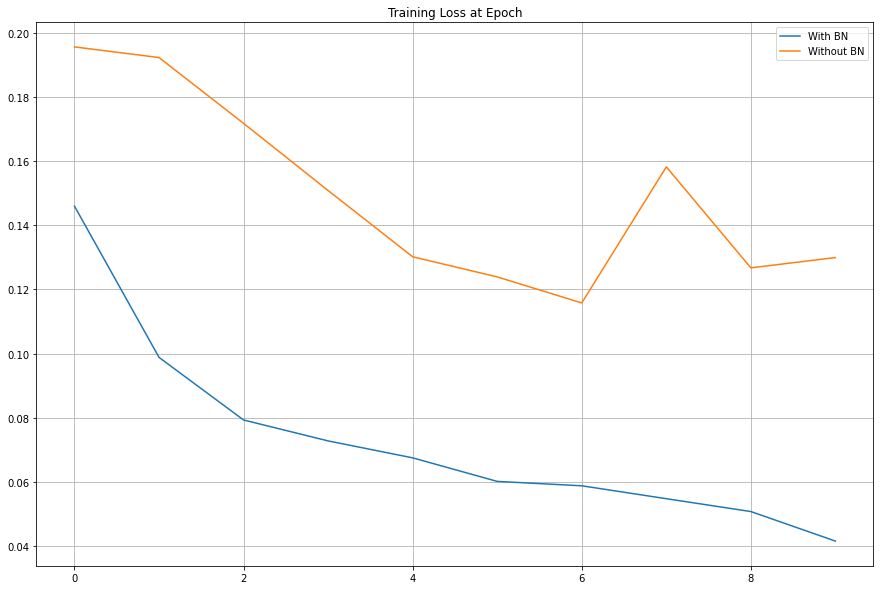

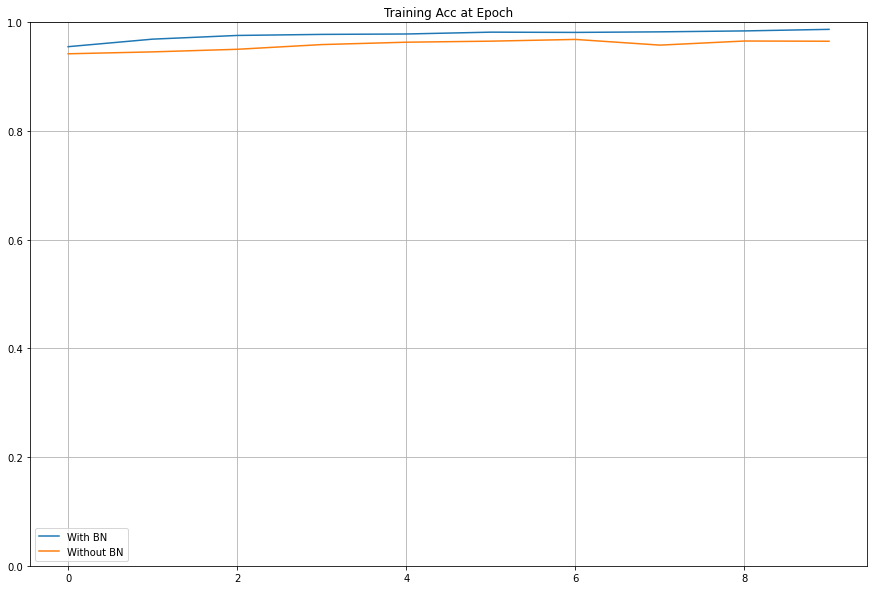

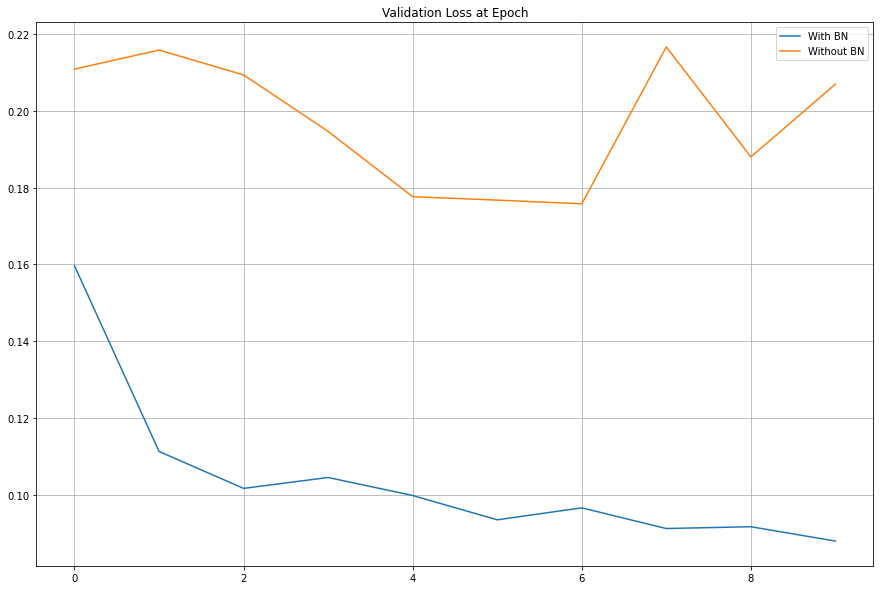

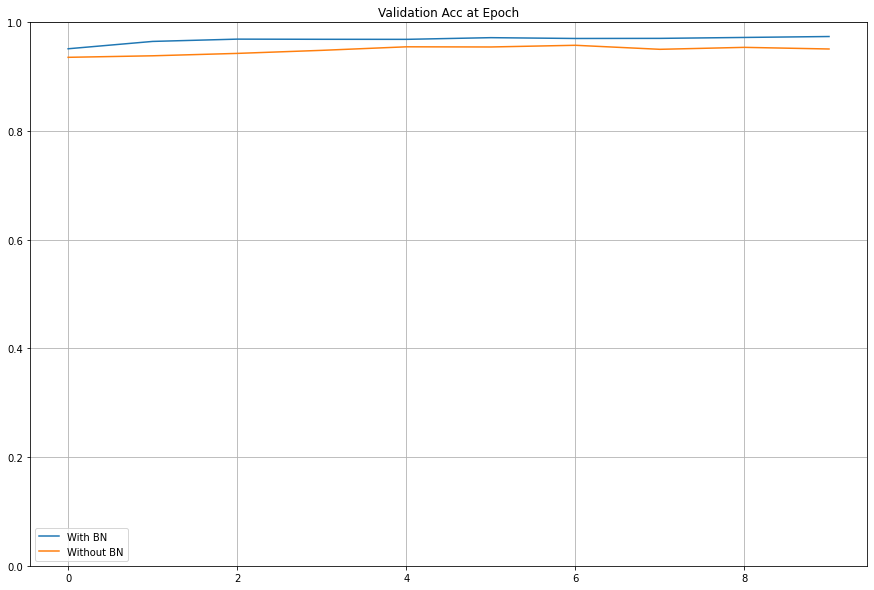

In [76]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')